In [75]:
import math
import matplotlib as mpl
import matplotlib.text as mtext
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

#mpl.style.use('default')


def autopct_both(pct, values):
    total = sum(values)
    val = int(round(pct*total/100.0))
    return f'{pct:.0f}% ({val:d})'


def autopct_abs(pct, total):
    val = int(round(pct*total/100.0))
    return f'{val:d}'


def format_labels(labels, pcts):
    return [f'{label} ({pct:.0f}%)' for label, pct in zip(labels, pcts)]


class CurvedText(mtext.Text):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, axes, **kwargs):
        super(CurvedText, self).__init__(x[0],y[0],' ', **kwargs)

        axes.add_artist(self)

        ##saving the curve:
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()

        ##creating the text objects
        self.__Characters = []
        for c in text:
            if c == ' ':
                ##make this an invisible 'a':
                t = mtext.Text(0,0,'a')
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0,0,c, **kwargs)

            #resetting unnecessary arguments
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder +1)

            self.__Characters.append((c,t))
            axes.add_artist(t)


    ##overloading some member functions, to assure correct functionality
    ##on update
    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c,t in self.__Characters:
            t.set_zorder(self.__zorder+1)

    def draw(self, renderer, *args, **kwargs):
        """
        Overload of the Text.draw() function. Do not do
        do any drawing, but update the positions and rotation
        angles of self.__Characters.
        """
        self.update_positions(renderer)

    def update_positions(self,renderer):
        """
        Update positions and rotations of the individual text elements.
        """

        #preparations

        ##determining the aspect ratio:
        ##from https://stackoverflow.com/a/42014041/2454357

        ##data limits
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
        ## Axis size on figure
        figW, figH = self.axes.get_figure().get_size_inches()
        ## Ratio of display units
        _, _, w, h = self.axes.get_position().bounds
        ##final aspect ratio
        aspect = ((figW * w)/(figH * h))*(ylim[1]-ylim[0])/(xlim[1]-xlim[0])

        #points of the curve in figure coordinates:
        x_fig,y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
            (i,j) for i,j in zip(self.__x,self.__y)
            ]))
        )

        #point distances in figure coordinates
        x_fig_dist = (x_fig[1:]-x_fig[:-1])
        y_fig_dist = (y_fig[1:]-y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist**2+y_fig_dist**2)

        #arc length in figure coordinates
        l_fig = np.insert(np.cumsum(r_fig_dist),0,0)

        #angles in figure coordinates
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]),(x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)


        rel_pos = 10
        for c,t in self.__Characters:
            #finding the width of c:
            t.set_rotation(0)
            t.set_va('center')
            bbox1  = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height

            #ignore all letters that don't fit:
            if rel_pos+w/2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue

            elif c != ' ':
                t.set_alpha(1.0)

            #finding the two data points between which the horizontal
            #center point of the character will be situated
            #left and right indices:
            il = np.where(rel_pos+w/2 >= l_fig)[0][-1]
            ir = np.where(rel_pos+w/2 <= l_fig)[0][0]

            #if we exactly hit a data point:
            if ir == il:
                ir += 1

            #how much of the letter width was needed to find il:
            used = l_fig[il]-rel_pos
            rel_pos = l_fig[il]

            #relative distance between il and ir where the center
            #of the character will be
            fraction = (w/2-used)/r_fig_dist[il]

            ##setting the character position in data coordinates:
            ##interpolate between the two points:
            x = self.__x[il]+fraction*(self.__x[ir]-self.__x[il])
            y = self.__y[il]+fraction*(self.__y[ir]-self.__y[il])

            #getting the offset when setting correct vertical alignment
            #in data coordinates
            t.set_va(self.get_va())
            bbox2  = t.get_window_extent(renderer=renderer)

            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0]-bbox1d[0])

            #the rotation/stretch matrix
            rad = rads[il]
            rot_mat = np.array([
                [math.cos(rad), math.sin(rad)*aspect],
                [-math.sin(rad)/aspect, math.cos(rad)]
            ])

            ##computing the offset vector of the rotated character
            drp = np.dot(dr,rot_mat)

            #setting final position and rotation:
            t.set_position(np.array([x,y])+drp)
            t.set_rotation(degs[il])

            t.set_va('center')
            t.set_ha('center')

            #updating rel_pos to right edge of character
            rel_pos += w-used


def make_pie(data, labels, clabel, autopct=None, pctdistance=None, explode=None, title=None, figsize=None, save=None):
    fig, ax = plt.subplots(figsize=figsize)
    wedges, texts, autotexts = ax.pie(
        data,
        labels=labels,
        autopct=autopct,
        wedgeprops=dict(width=0.5),
        pctdistance=pctdistance,
        explode=explode)

    ax.text(0, 0, clabel,
            size=20, fontweight='bold',
            ha='center', va='center')

    in_wedges = {'color': 'white',
                 'fontsize': 'small'}
    [t.update(in_wedges) for t in autotexts]

    plt.title(title,
              dict(fontsize=16,
                   fontweight='bold'))

    plt.savefig(save + '.pdf', bbox_inches='tight')


In [76]:
columns = ['From', 'To', 'When', 'Type', 'Energy']
data = pd.DataFrame([['Fission Products',       'Fuel',  'Prompt', 'KE', 168],
                     ['Fission Neutrons',  'Moderator',  'Prompt', 'KE',   5],
                     ['Fission γ',        'Everywhere',  'Prompt', 'EM',   7],
                     ['Decay β',                'Fuel', 'Delayed', 'KE',   8],
                     ['Decay γ',          'Everywhere', 'Delayed', 'EM',   7],
                     ['Antineutrinos',          'Lost',   'Never', 'KE',  12],
                     ['Capture γ',        'Everywhere', 'Delayed', 'EM',   5]],
                    columns=columns)

data

,From,To,When,Type,Energy
0,Fission Products,Fuel,Prompt,KE,168
1,Fission Neutrons,Moderator,Prompt,KE,5
2,Fission γ,Everywhere,Prompt,EM,7
3,Decay β,Fuel,Delayed,KE,8
4,Decay γ,Everywhere,Delayed,EM,7
5,Antineutrinos,Lost,Never,KE,12
6,Capture γ,Everywhere,Delayed,EM,5


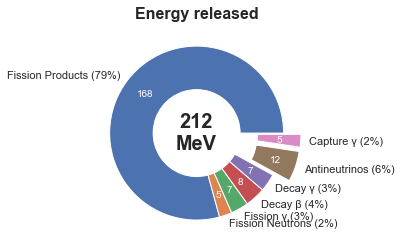

In [77]:
figsize=(6,4)

energy_from = data['Energy']

Qtot = energy_from.sum()
from_pcts = energy_from/Qtot*100

clabel = f'{Qtot}\nMeV'
autopct = lambda pct: autopct_abs(pct, Qtot)
pct_dis = 0.75
ex_dis = 0.2

make_pie(energy_from,
         format_labels(data['From'], from_pcts), clabel,
         autopct=autopct,
         pctdistance=pct_dis,
         explode=[0, 0, 0, 0, 0, ex_dis, ex_dis],
         title='Energy released',
         figsize=figsize,
         save='energy_released')

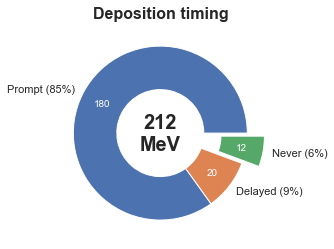

In [78]:
energy_when = data.groupby(by=['When'])['Energy'].sum()
energy_when.sort_values(inplace=True, ascending=False)

when_pcts = energy_when/Qtot*100

make_pie(energy_when,
         format_labels(energy_when.index, when_pcts), clabel,
         autopct=autopct,
         pctdistance=pct_dis,
         explode=[0, 0, ex_dis],
         title='Deposition timing',
         figsize=figsize,
         save='deposition_timing')

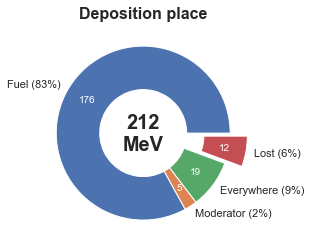

In [79]:
energy_to = data.groupby(by=['To'])['Energy'].sum()
energy_to = energy_to.reindex(['Fuel', 'Moderator', 'Everywhere', 'Lost'])

to_pcts = energy_to/Qtot*100

make_pie(energy_to,
         format_labels(energy_to.index, to_pcts), clabel,
         autopct=autopct,
         pctdistance=pct_dis,
         explode=[0, 0, 0, ex_dis],
         title='Deposition place',
         figsize=figsize,
         save='deposition_place')